In [39]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array

sys.path.append("..")

import torch

import model
import utils

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import data_loader
from config import get_config


# RAM model

In [2]:
# paths
plot_dir = "../plots/"
data_dir = "../data/"

# load images
imgs = []
paths = [data_dir + "./lenna.jpg", data_dir + "./cat.jpg"]
for i in range(len(paths)):
    img = utils.img2array(paths[i], desired_size=[512, 512], expand=True)
    imgs.append(torch.from_numpy(img))
imgs = torch.cat(imgs).permute((0, 3, 1, 2))

B, C, H, W = imgs.shape
l_t_prev = torch.FloatTensor(B, 2).uniform_(-1, 1)
h_t_prev = torch.zeros(B, 256)

ram = model.RecurrentAttention(64, 3, 2, C, 128, 128, 0.11, 256, 10)
h_t, l_t, _, _ = ram(imgs, l_t_prev, h_t_prev)

assert h_t.shape == (B, 256)
assert l_t.shape == (B, 2)


In [3]:
B

2

In [4]:
h_t.shape

torch.Size([2, 256])

In [5]:
l_t.shape

torch.Size([2, 2])

In [6]:
l_t

tensor([[-0.0777, -0.0408],
        [ 0.1505,  0.1170]])

In [7]:
h_t_prev.shape

torch.Size([2, 256])

# Glimpse Test

(1, 900)


(10, 30, 3)

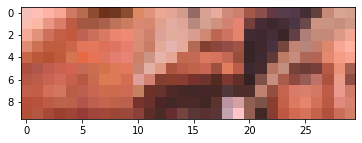

In [8]:
def bounding_box(x, y, size, color="w"):
    x = int(x - (size / 2))
    y = int(y - (size / 2))
    rect = patches.Rectangle(
        (x, y), size, size, linewidth=1, edgecolor=color, fill=False
    )
    return rect


# https://stackoverflow.com/questions/10657383/stitching-photos-together
def merge_images(image1, image2):
    """Merge two images into one, displayed side by side.
    """
    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new("RGB", (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result


# paths
data_dir = "../data/"


# load images
imgs = []
paths = [data_dir + "./lenna.jpg"]
for i in range(len(paths)):
    img = img2array(paths[i], desired_size=[512, 512], expand=True)
    imgs.append(torch.from_numpy(img))
imgs = torch.cat(imgs).permute(0,3, 1, 2)

#loc = torch.Tensor(2, 2).uniform_(-1, 1)
loc = torch.from_numpy(np.array([[0.0, 0.0], [0.0, 0.0]]))

num_patches = 3
scale = 4
patch_size = 10

ret = Retina(g=patch_size, k=num_patches, s=scale)
glimpse = ret.foveate(imgs, loc).data.numpy()

print(glimpse.shape)

glimpse = np.reshape(glimpse, [1, num_patches, 3, patch_size, patch_size])
glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])

merged = []
for i in range(len(glimpse)):
    g = glimpse[i]
    g = list(g)
    g = [array2img(l) for l in g]
    res = reduce(merge_images, list(g))
    merged.append(res)

merged = [np.asarray(l, dtype="float32") / 255.0 for l in merged]

plt.imshow(merged[0])

merged[0].shape


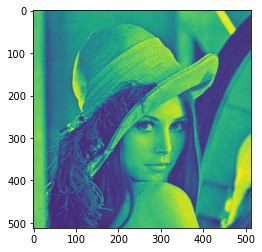

In [9]:
# paths
data_dir = "../data/"

# load images
imgs = []
paths = [data_dir + "./lenna.jpg"]
for i in range(len(paths)):
    img = img2array(paths[i], desired_size=[512, 512], expand=True)
    imgs.append(torch.from_numpy(img))
imgs = torch.cat(imgs).permute(0,3, 1, 2)
imgs.shape
glimpse = ret.foveate(imgs, loc).data.numpy()
plt.imshow(imgs[0][0])

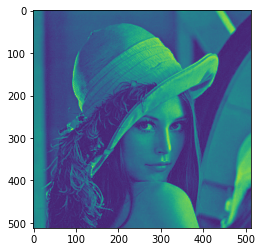

In [10]:
plt.imshow(imgs[0][1])

# Glimpse Test Single MNIST Example

In [11]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", train=False, download=True, transform=trans)


In [12]:
dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Text(0.5, 1.0, '4')

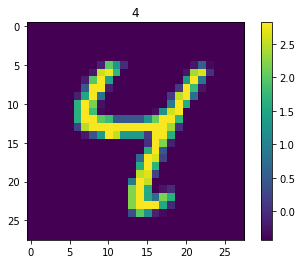

In [13]:
image, label = dataset[6]
plt.imshow(image[0])
plt.colorbar()
plt.title(label)

Text(0.5, 1.0, '1')

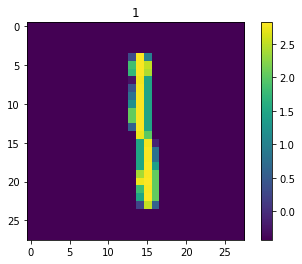

In [14]:
image, label = dataset[1236]
plt.imshow(image[0])
plt.colorbar()
plt.title(label)

In [15]:
image.shape

torch.Size([1, 28, 28])

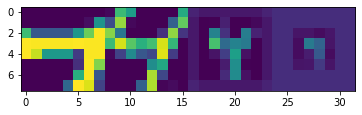

In [16]:
mnistImage, label = dataset[6]
mnistImage = mnistImage.unsqueeze(1)

#loc = torch.Tensor(2, 2).uniform_(-1, 1)
loc = torch.from_numpy(np.array([[0.0, 0.0]]))

num_patches = 4
scale = 2
patch_size = 8

ret = Retina(g=patch_size, k=num_patches, s=scale)
glimpse = ret.foveate(mnistImage, loc).data.numpy()


glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])


concat_glimpse = np.concatenate([glimpse[0, i] for i in range(glimpse.shape[1])], axis=1)
plt.imshow(concat_glimpse)

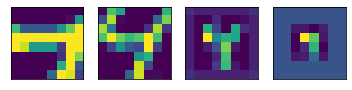

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=glimpse.shape[1])
for i, ax in enumerate(axs.flat):
    axs[i].imshow(glimpse[0,i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.show()

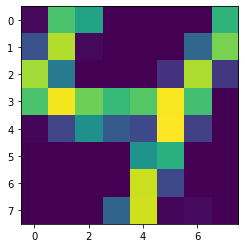

In [18]:
plt.imshow(glimpse[0,1])


# Do single episode using trained RAM model

In [25]:
#load the model (code from load_checkpoint function in trainer.py):

filename = "../models/ram_6_8x8_2_model_best.pth.tar"

ckpt = torch.load(filename) #model

In [46]:
ckpt

{'epoch': 25,
 'model_state': OrderedDict([('sensor.fc1.weight',
               tensor([[ 0.0378, -0.0696, -0.0329,  ...,  0.0586,  0.0988,  0.3163],
                       [-0.0886, -0.0049, -0.0248,  ..., -0.1871, -0.2779, -0.4385],
                       [ 0.1471,  0.1872,  0.0382,  ..., -0.1019,  0.0090, -0.0833],
                       ...,
                       [ 0.2834,  0.0403, -0.0723,  ...,  0.0263, -0.0249,  0.0073],
                       [-0.1895, -0.1080, -0.1454,  ...,  0.0397, -0.0233,  0.0308],
                       [-0.0668,  0.0194, -0.1657,  ..., -0.0203, -0.1444, -0.2218]])),
              ('sensor.fc1.bias',
               tensor([-5.0933e-02,  7.9121e-03, -9.9576e-02,  5.8374e-03,  2.7042e-02,
                       -9.8137e-02, -2.6935e-02, -1.9174e-02,  1.1136e-01, -7.3969e-02,
                        5.6347e-02, -3.7330e-02,  1.2721e-02, -1.4980e-03, -9.7262e-02,
                       -1.0028e-01, -5.2399e-02, -1.8454e-01, -1.7068e-01, -5.0722e-02,
        

In [45]:
# build RAM model
ram = model.RecurrentAttention(
    config.patch_size,
    config.num_patches,
    config.glimpse_scale,
    1, #number of channels, 1
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10, #number of classes?
)



ram.load_state_dict(ckpt["model_state"])


RecurrentAttention(
  (sensor): GlimpseNetwork(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=2, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=128, out_features=256, bias=True)
  )
  (rnn): CoreNetwork(
    (i2h): Linear(in_features=256, out_features=256, bias=True)
    (h2h): Linear(in_features=256, out_features=256, bias=True)
  )
  (locator): LocationNetwork(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (fc_lt): Linear(in_features=128, out_features=2, bias=True)
  )
  (classifier): ActionNetwork(
    (fc): Linear(in_features=256, out_features=10, bias=True)
  )
  (baseliner): BaselineNetwork(
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [36]:
type(ram)

model.RecurrentAttention

In [40]:
config, unparsed = get_config()

config.patch_size

8